In [3]:
# Calculate velocities at the sill
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.abspath('./TEF'))
import TEF_Variables as tef

In [ ]:
case_id = 1
file1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/weak_Tide_minhs/state_' + str(format(case_id,'03d')) + '.nc')
State = file1.isel(T=~file1.get_index("T").duplicated())
Grid = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/weak_Tide_minhs/grid_' + str(format(case_id,'03d')) + '.nc')



# Confine to the range of fjord
# state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
# grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))

HFacC = Grid.HFacC
areaC = Grid.HFacC * Grid.drF * Grid.dyF # Z Y X
areaW = Grid.HFacW * Grid.drF * Grid.dyG # Z Y Xp1
sW = np.where(HFacC[-1,40,1:] == 0)[-1][0] # Sill west edge index
sE = np.where(HFacC[-1,40,1:] == 0)[-1][-1] # Sill east edge index
sC = np.ceil((sW+sE)/2).astype(int) # Sill crest index (178)
print(sC)

In [ ]:
areaW.data[:,:,-2].sum(), areaC.data[:,:,-1].sum()

In [4]:
def sill_vel(datapath, case_id):
    
    file1 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    State = file1.isel(T=~file1.get_index("T").duplicated())
    Grid = xr.open_dataset(datapath+'/grid_' + str(format(case_id,'03d')) + '.nc')
    
    HFacC = Grid.HFacC
    areaC = Grid.HFacC * Grid.drF * Grid.dyF # Z Y X
    areaW = Grid.HFacW * Grid.drF * Grid.dyG # Z Y Xp1
    sW = np.where(HFacC[-1,40,1:] == 0)[-1][0] # Sill west edge index
    sE = np.where(HFacC[-1,40,1:] == 0)[-1][-1] # Sill east edge index
    sC = np.ceil((sW+sE)/2).astype(int) # Sill crest index (178)
    
    
    state = State.isel(Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(Y=range(35,45))
    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC2 = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC2


    tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,sC,23,testing=False)
    qin1, qout1, sin1, sout1 = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    
    
    U0 = 1e-4 * case_id
    Ut = U0 * areaC.data[:,:,-1].sum() / areaC.data[:,:,sC].sum() # Maximum tidal velocity at the sill
    t0 = 89
    Usil = U[t0:,:,:,sC].mean(axis=(0,2))
    Qin = qin1[t0:].mean()
    Qout = -qout1[t0:].mean()
    Qe = (Qin + Qout) / 2
    Ue = Qe / (areaC.data[:,:,sC].sum()) # Exchange velocity at the sill
    Ur = round(Ut/Ue,2)
    
    return Ut, Ue, Ur, Usil, Qe

In [ ]:
np.arange(5) + 1

In [9]:
#case = np.arange(5) + 1
path1 = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase'
case1 = np.array([1,2])
ut1 = np.empty(len(case1))
ue1 = np.empty(len(case1))
ur1 = np.empty(len(case1))
us1 = np.empty(shape=(len(case1), 90))
Qe1 = np.empty(len(case1))

for i in range(len(case1)):
    
    ut1[i], ue1[i], ur1[i], us1[i,:], Qe1[i] = sill_vel(path1, case1[i])


path2 = '/work/oceans/wbao/MITgcm_results/iceplume/6_sTide_minhs'
case2 = np.array([1,2,3,4,5])
ut2 = np.empty(len(case2))
ue2 = np.empty(len(case2))
ur2 = np.empty(len(case2))
us2 = np.empty(shape=(len(case2), 90))
Qe2 = np.empty(len(case2))

for j in range(len(case2)):
    
    ut2[j], ue2[j], ur2[j], us2[j,:], Qe2[j] = sill_vel(path2, case2[j])

  time 0 out of 120


/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:269: RuntimeWarning: invalid value encountered in true_divide
  Sm = QSm/Qm
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:273: RuntimeWarning: invalid value encountered in true_divide
  S2m = QS2m/Qm


  time 0 out of 120
  time 0 out of 120


/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:268: RuntimeWarning: invalid value encountered in true_divide
  Sp = QSp/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:269: RuntimeWarning: invalid value encountered in true_divide
  Sm = QSm/Qm
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:272: RuntimeWarning: invalid value encountered in true_divide
  S2p = QS2p/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:273: RuntimeWarning: invalid value encountered in true_divide
  S2m = QS2m/Qm


  time 0 out of 120


/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:268: RuntimeWarning: invalid value encountered in true_divide
  Sp = QSp/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:269: RuntimeWarning: invalid value encountered in true_divide
  Sm = QSm/Qm
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:272: RuntimeWarning: invalid value encountered in true_divide
  S2p = QS2p/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:273: RuntimeWarning: invalid value encountered in true_divide
  S2m = QS2m/Qm


  time 0 out of 120


/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:268: RuntimeWarning: invalid value encountered in true_divide
  Sp = QSp/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:269: RuntimeWarning: invalid value encountered in true_divide
  Sm = QSm/Qm
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:272: RuntimeWarning: invalid value encountered in true_divide
  S2p = QS2p/Qp
/home/1959/Scripts/Jupyter-Iceplume/TEF/TEF_Variables.py:273: RuntimeWarning: invalid value encountered in true_divide
  S2m = QS2m/Qm


FileNotFoundError: [Errno 2] No such file or directory: '/work/oceans/wbao/MITgcm_results/iceplume/6_sTide_minhs/state_004.nc'

In [10]:
ue1*2, ue2*2, ur1, ur2, Qe1, Qe2

(array([0.14927527, 0.15236062]),
 array([0.15686093, 0.2028279 , 0.2780752 , 0.528     , 0.66      ]),
 array([0.88, 1.16]),
 array([0.84      , 1.3       , 1.42      , 0.07447517, 0.07479217]),
 array([2388.40434111, 3656.6548045 ]),
 array([2509.77482834, 3245.2463326 , 4449.20315977, 2383.20547266,
        2393.34934488]))

In [8]:
Qe=[2388,2388,2391,2393,2510,2393]
Ut = np.concatenate([ut1, 10*ut2])
Ue = np.concatenate([2*ue1, 2*ue2])
Usill = np.concatenate([us1, us2])
Ut, Ue, Ut/Ue

(array([0.066, 0.132, 0.66 , 1.32 , 1.98 , 2.64 , 3.3  ]),
 array([0.14925309, 0.14924685, 0.14946376, 0.14891398, 0.14873957,
        0.14895034, 0.14958433]),
 array([ 0.44220189,  0.88444077,  4.41578619,  8.86417793, 13.31185744,
        17.72402778, 22.06113375]))

In [ ]:
# Velocities at the sill
U0 = 1e-3 # Tidal amplitude at OBC
Ut = U0 * areaC.data[:,:,-1].sum() / areaC.data[:,:,sC].sum() # Maximum tidal velocity at the sill

t0 = 89
Ue = (qin1[t0:].mean()-qout1[t0:].mean()) / (2*areaC.data[:,:,sC].sum()) # Exchange velocity at the sill

print(Ut,Ue)

In [4]:
# Save outputs
Vel_ds = xr.Dataset(
    data_vars={'Ut' : ut,
    'Ue' : ue,
    'Ur' : ur})

outdir = "/home/1959/Parameters/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

Vel_ds.to_netcdf(outdir + 'wTide_maxhs_vel.nc')

In [ ]:
(qin1-qout1) / (2*areaC.data[:,:,sC].sum())

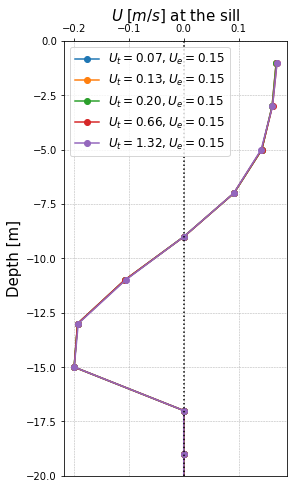

In [33]:
# Plot velocity profiles at the sill

fig1 = plt.figure(figsize=(4,8))
fig1.tight_layout()  
ax1 = fig1.add_subplot(111)

depth = xr.open_dataset(path1+'/state_001.nc').Z.data

ax1.plot(Usill[0,:],depth,'o-',lw=1.5,label=r'$U_t=0.07,U_e=0.15$')
ax1.plot(Usill[1,:],depth,'o-',lw=1.5,label=r'$U_t=0.13,U_e=0.15$')
ax1.plot(Usill[2,:],depth,'o-',lw=1.5,label=r'$U_t=0.20,U_e=0.15$')
ax1.plot(Usill[3,:],depth,'o-',lw=1.5,label=r'$U_t=0.66,U_e=0.15$')
ax1.plot(Usill[4,:],depth,'o-',lw=1.5,label=r'$U_t=1.32,U_e=0.15$')
ax1.axvline(x=0,color='k',linestyle=':')
ax1.legend(loc='best',fontsize=12)
ax1.set_xlabel(r'$U\;[m/s]$ at the sill', size = 15)
ax1.set_ylabel(r'Depth [m]',size = 15)
#ax4.set_xlim(-4,4)
ax1.set_ylim(-20,0)    
ax1.xaxis.set_label_position('top') # this moves the label to the top
ax1.xaxis.set_ticks_position('top') # this moves the ticks to the top
#ax4.yaxis.set_visible(False) # This erases the y ticks
ax1.grid(ls='--', lw=.5)

